In [13]:
import os
os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
# PDC-Net path
sys.path.append('../DenseMatching/')
from easydict import EasyDict as easydic
from utils_flow.pixel_wise_mapping import remap_using_flow_fields
from model_selection import select_model

from skimage import io
from matplotlib import pyplot as plt
import cv2
import numpy as np
import torch
from config import get_life_args, get_raft_args
import configargparse
# LIFE/MS path
#sys.path.append('./LIFE')
#sys.path.append('./LIFE/core')
sys.path.append('./Twins')
sys.path.append('./Twins/core')
#sys.path.append('./MultiScale')
#sys.path.append('./MultiScale/core')
from flow_estimator import Flow_estimator
from core.utils.utils import image_flow_warp
# metrics
from skimage.metrics import mean_squared_error as mse 
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import datetime
# psnr
from skimage.util.dtype import dtype_range
from skimage._shared.utils import warn, check_shape_equality
# ssim
from skimage.util.arraycrop import crop
from scipy.ndimage import uniform_filter, gaussian_filter

In [14]:
def show_input_images(scene_images, target_images):
    plt.figure(figsize=(15,15))
    num = len(scene_images)
    plt.subplot(221), plt.imshow(scene_images[0]), plt.axis('off')
    plt.subplot(222), plt.imshow(target_images[0]), plt.axis('off')
    plt.subplot(223), plt.imshow(scene_images[num-1]), plt.axis('off')
    plt.subplot(224), plt.imshow(target_images[num-1]), plt.axis('off')
    plt.show()

In [15]:
def blend(out, source, scene, blend_type):
    intensity = np.linalg.norm(out, axis=2)
    mask = (intensity == 0)[:,:,np.newaxis]    
    if blend_type == 'light':                                    
        result = (out * (1 - mask) + source * mask).astype(np.uint8)
    else:
        result = (out * (1 - mask) + scene * mask).astype(np.uint8) 
    return result, mask


In [16]:
def blend_homography(scene_images, target, source=None, blend_type='scale', detector='SIFT'):
    #H, W = 480, 640
    #target = cv2.resize(target, (W, H))
    print('detector: '+detector)
    if detector == 'ORB':
        detect = cv2.ORB_create()    
    elif detector == 'SIFT':
        detect = cv2.SIFT_create()
    else:
        raise ValueError('detector not implemented')
    blends = []
    masks = []
    for scene in scene_images:
        #ori_H, ori_W = scene.shape[:2]
        #scene = cv2.resize(scene, (W, H))        
        kp1, des1 = detect.detectAndCompute(target, None)
        kp2, des2 = detect.detectAndCompute(scene, None)           
        if des1 is None or des2 is None:
            blends.append(None)   
            continue
        
        if detector == 'ORB':
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)                
            matches = bf.match(des1, des2)
            matches = sorted(matches, key=lambda x: x.distance)
        elif detector == 'SIFT':
            FLANN_INDEX_KDTREE = 0
            indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            searchParams = dict(checks=50)
            flann = cv2.FlannBasedMatcher(indexParams, searchParams)    
            if len(des1)<2 or len(des2)<2:
                blends.append(None)
                continue
            matches = flann.knnMatch(des1, des2, k=2)
            matches = [m for m,n in matches if m.distance < 0.7*n.distance]
        else:
            raise ValueError('detector {} not implemented'.format(detector))
        if len(matches) < 4:
            blends.append(None)
            continue
        
        
        #print(len(matches))
        #img3 = cv2.drawMatches(target, kp1, scene, kp2, matches[:50], target, flags=2)
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:50]]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:50]]).reshape(-1,1,2)        

        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is None:
            blends.append(None)
            continue
        out = cv2.warpPerspective(target, M, (scene.shape[1], scene.shape[0]))        

        blend_i, mask_i = blend(out, source, scene, blend_type)
        #blend_i = cv2.resize(blend_i, (ori_W, ori_H))
        blends.append(blend_i)
        masks.append(mask_i)
    return blends, masks
    plt.figure(figsize=(20,30))
    plt.subplot(131), plt.imshow(target[:,:,::-1]), plt.title('target')
    plt.subplot(132), plt.imshow(scene[:,:,::-1]), plt.title('scene')
    plt.subplot(133), plt.imshow(blend[:,:,::-1]), plt.title('output')

In [17]:
def blend_pdc(scene_images, target, flow_estimator, estimate_uncertainty, source=None, blend_type='scale'):            
    #H, W = 480, 640
    #img1 = cv2.resize(target, (W, H))    
    blends = []
    masks = []
    for scene in scene_images:        
        #H_ori, W_ori = scene.shape[:2]                
        #img2 = cv2.resize(scene, (W, H))
        target = cv2.resize(target, (scene.shape[1], scene.shape[0]))
        Is_original = np.ascontiguousarray(target)
        It_original = np.ascontiguousarray(scene)
        Is_tensor = torch.from_numpy(Is_original).permute(2,0,1).unsqueeze(0)
        It_tensor = torch.from_numpy(It_original).permute(2,0,1).unsqueeze(0)
        with torch.no_grad():
            flow_est, uncertainty_est = flow_estimator.estimate_flow_and_confidence_map(Is_tensor, It_tensor)

        flow = flow_est[0].permute([1,2,0]).cpu().detach().numpy()
        out = remap_using_flow_fields(Is_original, flow[:,:,0], flow[:,:,1])
        #img_warp = cv2.resize(img_warp, (W_ori, H_ori))
        
        blend_i, mask_i = blend(out, source, scene, blend_type) 
        #blend_i = cv2.resize(blend_i, (W_ori, H_ori))
        blends.append(blend_i)
        masks.append(mask_i)
    return blends, masks
        

    '''
        confidence_map = uncertainty_est['p_r'].squeeze().detach().cpu().numpy()

        plt.figure(figsize=(20,30))
        plt.subplot(141), plt.imshow(img1_ori[:,:,::-1]), plt.axis('off')
        plt.subplot(142), plt.imshow(img2_ori[:,:,::-1]), plt.axis('off')
        plt.subplot(143), plt.imshow(blend[:,:,::-1]), plt.axis('off')
        #plt.subplot(144), plt.imshow(confidence_map)
    '''

In [18]:
def PSNR(image_true, image_test, mask=None):
    check_shape_equality(image_true, image_test)    

    if image_true.dtype != image_test.dtype:
        warn("Inputs have mismatched dtype. Setting data_range based on "
                "im_true.", stacklevel=2)
    dmin, dmax = dtype_range[image_true.dtype.type]
    true_min, true_max = np.min(image_true), np.max(image_true)
    if true_max > dmax or true_min < dmin:
        raise ValueError(
            "im_true has intensity values outside the range expected for "
            "its data type. Please manually specify the data_range")
    if true_min >= 0:
        # most common case (255 for uint8, 1 for float)
        data_range = dmax
    else:
        data_range = dmax - dmin
    
    image_true = image_true.astype(np.float64)
    image_test = image_test.astype(np.float64)
    if mask is None:                      
        err = np.mean((image_true - image_test) ** 2, dtype=np.float64)
    else:
        mask = 1-mask
        cnt = np.count_nonzero(mask) * image_true.shape[2]
        sum = np.sum((image_true*mask - image_test*mask)**2)    
        err = sum/cnt
        '''
        plt.figure(facecolor='white')
        plt.subplot(121), plt.imshow(image_true.astype(np.uint8)*mask)
        plt.subplot(122), plt.imshow(image_test.astype(np.uint8)*mask)
        '''
    return 10 * np.log10((data_range ** 2) / err)

In [19]:
def SSIM(im1, im2, multichannel=True, mask=None):
    check_shape_equality(im1, im2)

    if multichannel:
        # loop over channels
        nch = im1.shape[-1]
        mssim = np.empty(nch)
        for ch in range(nch):
            ch_result = SSIM(im1[..., ch], im2[..., ch], multichannel=False, mask=mask)
            mssim[..., ch] = ch_result
        mssim = mssim.mean()
        return mssim

    if im1.dtype != im2.dtype:
        warn("Inputs have mismatched dtype.  Setting data_range based on im1.dtype.", stacklevel=2)
    dmin, dmax = dtype_range[im1.dtype.type]
    data_range = dmax - dmin
    
    K1 = 0.01
    K2 = 0.03
    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2

    # ndimage filters need floating point data
    im1 = im1.astype(np.float64)
    im2 = im2.astype(np.float64)

    if mask is None:
        mask = np.zeros_like(im1)
        x,y = np.nonzero(1-mask)
    else:
        x,y,_ = np.nonzero(1-mask)
    im1_pixel = im1[x,y]
    im2_pixel = im2[x,y]

    ux = np.mean(im1_pixel)
    uy = np.mean(im2_pixel)
    uxy = np.mean(im1_pixel*im2_pixel)
    vx = np.var(im1_pixel)
    vy = np.var(im2_pixel)
    vxy = uxy - ux*uy

    ssim = (2*ux*uy+C1)*(2*vxy+C2)/((ux**2+uy**2+C1)*(vx+vy+C2))
    return ssim


In [20]:
def metrics(id, output_images, masks, save_root, scene_images=None, source=None, blend_type='scale', with_mask=False):   
    if blend_type != 'light' and len(output_images)!=len(scene_images):
        raise ValueError('output images should have the same number as scene images')
    save_file = os.path.join(save_root, 'output.txt')
    result = {'p':[], 's':[], 'ce':[]}
    with open(save_file, 'a') as f:
        print('id: {}'.format(str(id).zfill(4)))
        f.write('id: {}\n'.format(str(id).zfill(4)))
        for i, output in enumerate(output_images):
            if output is None: 
                result['p'].append(-1)
                result['s'].append(-1)
                result['ce'].append(-1)
                print('no.{:2d}\t Failed'.format(i))
                f.write('no.{:2d}\t Failed\n'.format(i))
                continue

            if blend_type == 'light':
                scene = source
            else:
                scene = scene_images[i]

            # print(output.shape[:2], scene.shape[:2])
            if not with_mask:
                p = psnr(output, scene)
                s = ssim(output, scene, multichannel=True)                
            else:
                mask = masks[i]
                p = PSNR(output, scene, mask=mask)
                s = SSIM(output, scene, multichannel=True, mask=mask)                                
                #plt.figure(facecolor='white')
                #plt.subplot(121), plt.imshow(output*(1-mask)), plt.title('output'), plt.axis('off')
                #plt.subplot(122), plt.imshow(scene*(1-mask)), plt.title('scene'), plt.axis('off')
                
            result['p'].append(round(p, 2))
            result['s'].append(round(s, 2))            
            #print('no.{:2d}\t PSNR:{:.2f}\t SSIM:{:.2f}\t census error:{:.2f}'.format(i, p, s, ce))
            print('no.{:2d}\t PSNR:{:.2f}\t SSIM:{:.2f}\t'.format(i, p, s))
            f.write('no.{:2d}\t PSNR:{:.2f}\t SSIM:{:.2f}\t\n'.format(i, p, s))
    return result

In [21]:
def blend_life(scene_images, target, estimator, source=None, blend_type='scale'):    
    #H, W = 480, 640    
    blends = []
    masks = []
    for scene in scene_images:        
        #ori_H, ori_W = scene.shape[:2]
        #scene = cv2.resize(scene, (W, H))
        target = cv2.resize(target, (scene.shape[1], scene.shape[0]))
        flow = estimator.estimate(scene, target)                
        out = image_flow_warp(target, flow[0].permute([1,2,0]))
        
        blend_i, mask_i = blend(out, source, scene, blend_type)
        blends.append(blend_i)
        masks.append(mask_i)
    return blends, masks

In [22]:
def eval(id, 
         scene_images, 
         target,           
         save_root, 
         blend_method='life',
         blend_type='scale', 
         estimator=None, 
         flow_estimator=None, 
         estimate_uncertainty=None, 
         source=None,
         detector='SIFT',
         with_mask = False,
         draw = True):   
    '''
    Args:
        @id: (int) target image id, for logging
        @scene_images: (list) test scene images
        @target: (array) target image
        @save_root: (string) 
        @blend_method: (string, 'life') ['life', 'homography', 'pdc']
        @blend_type: (string, 'scale') ['scale', 'light', 'viewpoint']
        @estimator: model to estimate when blend_method=='life'
        @flow_estimator: model to estimate when blend_method=='pdc'
        @estimate_uncertainty: check result uncertainty when blend_method=='pdc'
        @source: source image to calculate metrics when blend_type=='lighting'
        @detector: (string, 'SIFT) ['SIFT', 'ORB'] detector used in homography
        @with_mask: (bool) calculate metrics with or without mask
        @draw: (bool) show results or not
    '''
    if blend_method in ['life', 'raft', 'biraft', 'ms', 'twins']:
        if estimator is None:
            raise ValueError('estimator not set')
        out, mask = blend_life(scene_images, target, estimator=estimator, source=source, blend_type=blend_type)
    elif blend_method == 'homography':        
        out, mask = blend_homography(scene_images, target, source=source, blend_type=blend_type, detector=detector)
    elif blend_method == 'pdc':
        if flow_estimator is None:
            raise ValueError('estimator not set')
        out, mask = blend_pdc(scene_images, target, flow_estimator=flow_estimator, estimate_uncertainty=estimate_uncertainty, source=source, blend_type=blend_type)
    else:
        raise ValueError('blend method has not been implemented')
    if blend_type == 'light':
        result = metrics(id, out, mask, save_root=save_root, source=source, blend_type=blend_type, with_mask=with_mask)
    else:
        result = metrics(id, out, mask, save_root=save_root, scene_images =scene_images, blend_type=blend_type, with_mask=with_mask)
    
    #if not with_mask and draw:
    if draw: 
        save_root = os.path.join(save_root, str(id).zfill(4))
        if not os.path.exists(save_root):
            os.makedirs(save_root)
        for i in range(len(scene_images)): 
            if out[i] is None:
                continue
            title = 'PSNR: '+str(result['p'][i])+' SSIM: '+str(result['s'][i])
            plt.figure(figsize=(10,15), facecolor='white')       
            plt.subplot(1, 3, 1)
            plt.imshow(target), plt.title('target '+str(id).zfill(4)), plt.axis('off')        
            plt.subplot(1, 3, 2)
            plt.imshow(scene_images[i]), plt.title('scene '+str(i).zfill(4)), plt.axis('off')        
            plt.subplot(1, 3, 3)
            if not with_mask:
                plt.imshow(out[i]), plt.title(title), plt.axis('off')
            else:
                plt.imshow(out[i]*(1-mask[i])), plt.title(title), plt.axis('off')
            plt.savefig(os.path.join(save_root,str(i)+'.png'), dpi=200, bbox_inches='tight')
            io.imsave(os.path.join(save_root, str(i)+'_'+title+'.png'), cv2.resize(out[i],None,fx=0.25,fy=0.25))
    return (out, result)

In [11]:
def run(root = './assets/',
        blend_type = 'scale',
        blend_method = 'life', 
        img_num = 5, 
        start_id = 0,
        scn_num = 10,
        source_id = -1,
        H = 480,
        W = 640,
        with_mask = False,
        draw = True,
        detector="SIFT",
        multisample=True,
        folder=""):
    '''
    Args:
        @root: (string, './assets/') image data root
        @blend_type: (string, 'scale) ['scale', 'light', 'viewpoint', 'deformation', 'occlusion']
        @blend_method: (string, 'life') ['life', 'homography', 'pdc']
        @img_num: (int, 5) number of test images
        @start_id: (int, 0) test from image with id=start_id
        @scn_num: (int, 10) number of scene images per test image
        @source_id: if blend_type=='light', source id should be specified for metrics calculation
        @(W, H): resize images
        @with_mask: caculate PSNR/SSIM with or without mask
        @draw: (bool)
        @detector: (string, 'SIFT') ['SIFT', 'ORB']
        @multisample: (bool, True) if False(not one of blend_type), specify scene images folder
    Ouput:
        folder '{blend_method}_output_{time}' with output images and output.txt(metrics) will be created under folder {blend_type}
    '''
    # path setting
    if blend_type == 'light':
        if source_id == -1:
            raise FileExistsError('no source image id specified.')    
    if multisample:
        scene_root = os.path.join(root, blend_type)
    else:
        if folder=="":
            raise FileNotFoundError("input folder name")
        scene_root = os.path.join(root, folder) 
    time = datetime.datetime.now()
    suffix = datetime.datetime.strftime(time, '%m%d%H%M')
    if not with_mask:
        save_root = os.path.join(scene_root, blend_method+'_output_'+suffix)
    else:
        save_root = os.path.join(scene_root, blend_method+'_output_mask_'+suffix)
    if not os.path.exists(save_root):
        os.makedirs(save_root)

    # data loading
    if H > W:
        H, W = W, H
    scene_images = []
    target_images = []    
    for id in range(img_num):
        id = id + start_id
        scene_image = []
        for i in range(scn_num):
            scene_path = os.path.join(scene_root, str(id).zfill(4) + "_" + blend_type + "_"+str(i)+".jpg")
            scene = io.imread(scene_path)
            if scene.shape[0] > scene.shape[1]: # H > W
                scene = cv2.resize(scene, (H, W))
            else:
                scene = cv2.resize(scene, (W, H))
            scene_image.append(scene)
        scene_images.append(scene_image)

        target_path = os.path.join(root, str(id).zfill(4) + ".jpg")
        target_image = io.imread(target_path)
        if target_image.shape[0] > target_image.shape[1]: # H > W
            target_image = cv2.resize(target_image, (H, W))
        else:
            target_image = cv2.resize(target_image, (W, H))        
        target_images.append(target_image)
    print('input {}x{} scene images'.format(len(scene_images), len(scene_images[0])))
    print('input {} target images'.format(len(target_images)))
    # show_input_images(scene_images, target_images)

    # model loading
    print('blend method: ', blend_method)
    if blend_method in ['life', 'raft', 'biraft', 'ms', 'twins']:            
        if blend_method == 'life':
            args = get_life_args()    
        else:
            args = get_raft_args()
            if blend_method == 'biraft':
                args.model = './model/biRAFT_latest.pth'
            elif blend_method == 'ms':
                args.model = './model/MultiScale_latest.pth'
            elif blend_method=='twins':
                args.model = "./model/RAFT_twins_bs12_ep20.pth"
                #args.fnet = "twins"
        print(args)
        estimator = Flow_estimator(args, method=blend_method)
    elif blend_method == 'pdc':
        args = easydic({
            'model': 'PDCNet',
            'pre_trained_model_type': 'megadepth',
            'path_to_pre_trained_models': '/home/weihong/work/Optical_Flow/DenseMatching/pre_trained_models',
            'local_optim_iter': 7,
            'optim_iter': 3,
            'network_type': None
        })
        flow_estimator, estimate_uncertainty = select_model(
            args.model, 
            args.pre_trained_model_type, 
            args,
            args.optim_iter, 
            args.local_optim_iter,
            path_to_pre_trained_models=args.path_to_pre_trained_models)
            
    ID = []
    #out_images = []
    #results = []
    p = []
    s = []
    for id in range(img_num):
        scene = scene_images[id]
        target = target_images[id]
        source = scene[source_id]  
        if blend_method in ['life', 'raft', 'biraft', 'ms', 'twins']:
            out, result = eval(id, scene, target, blend_method=blend_method, save_root=save_root, source=source, blend_type=blend_type, estimator=estimator, with_mask=with_mask, draw=draw)
        elif blend_method == 'pdc':
            out, result = eval(id, scene, target, blend_method=blend_method, save_root=save_root, source=source, blend_type=blend_type, flow_estimator=flow_estimator, estimate_uncertainty=estimate_uncertainty, with_mask=with_mask, draw=draw)
        elif blend_method == 'homography':
            out, result = eval(id, scene, target, blend_method=blend_method, save_root=save_root, source=source, blend_type=blend_type, with_mask=with_mask, detector=detector, draw=draw)
        else:
            raise ValueError('blend method not inplemented')
        #out_images.append(out)
        #results.append(result)
        #ID.append(str(id).zfill(4))
        p.append(result['p'])
        s.append(result['s'])
    p_array = np.asarray(p).flatten()
    s_array = np.asarray(s).flatten()
    print(blend_method+'\t PSNR: {:.2f}/{:.2f}\t SSIM: {:.2f}/{:.2f}'.format(np.mean(p_array), np.median(p_array), np.mean(s_array), np.median(s_array)))
    
    #draw_result(ID, out_images, results)

input 1x5 scene images
input 1 target images
blend method:  twins
Namespace(dim_corr=192, dim_corr_all=256, dim_corr_coarse=64, iters=12, mixed_precision=True, model='./model/RAFT_twins_bs12_ep20.pth', small=False)


/home/weihong/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/weihong/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272172048/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/weihong/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use

id: 0000
no. 0	 PSNR:8.43	 SSIM:0.14	
no. 1	 PSNR:8.35	 SSIM:0.15	
no. 2	 PSNR:8.39	 SSIM:0.14	
no. 3	 PSNR:7.93	 SSIM:0.12	
no. 4	 PSNR:9.25	 SSIM:0.15	
twins	 PSNR: 8.47/8.39	 SSIM: 0.14/0.14


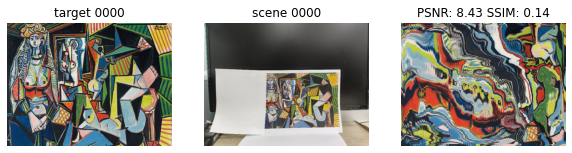

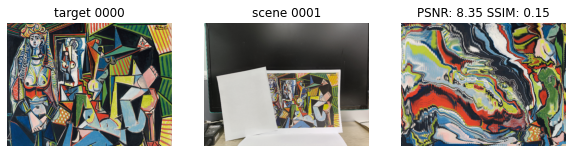

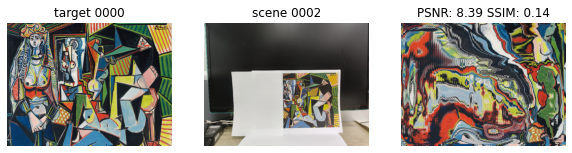

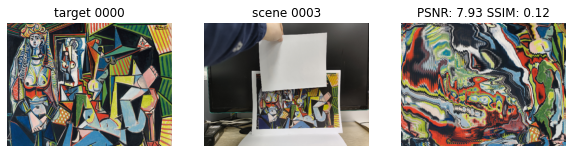

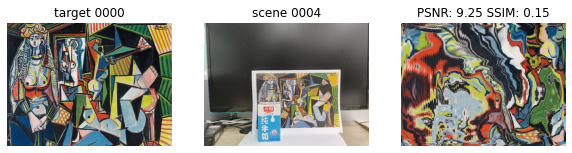

In [12]:
''' 数据集格式
|-deformation (scene images)
    |-0000_deformation_0.jpg
    |-0000_deformation_1.jpg
    |-...
    |-0001_deformation_0.jpg
    |-...
|-light
|-occlusion
|-scale
|-viewpoint
|-0000.jpg (target image)
|-0001.jpg
|-...
'''
# life / multiscale / twins 记得改模型路径！！！
run(blend_type='occlusion', blend_method='twins', img_num=1, scn_num=5, source_id=1, with_mask=False, multisample=True, folder="minions", start_id=0, draw=True, detector="SIFT")